In [1]:
# load required library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
import datetime

from scipy.stats import pearsonr
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

sns.set()

In [2]:
# Example dataset: air quality
# Testing datetime format and missing data handling
air_quality = pd.read_csv('AirQualityUCI_req.csv')
air_quality['Datetime'] = air_quality['Date'] + " " + air_quality['Time']
del air_quality['Date'], air_quality['Time']
air_quality['text_number'] = '3' 
air_quality.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime,text_number
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,10/03/2004 18:00:00,3
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,10/03/2004 19:00:00,3
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,10/03/2004 20:00:00,3
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,10/03/2004 21:00:00,3
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,10/03/2004 22:00:00,3


In [3]:
# Example dataset: mtcars
# Testing categorical data
mtcars = pd.read_csv('mtcars.csv')
mtcars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


# Project Outline

## Descriptive Statistics

###  Dataset Overview

1. Number of variables

2. Number of observations

3. Memory usage

## Missing Values

1. Visualize missing values using heatmap

2. Suggestions for handling missing value

## Variable Types

1. Print out current data types from Pandas

2. Type conversion suggestions: 

 * String datetime -> datetime
 
 * Small interger (for example: boolean)  -> categorical type
 
 * String float -> float
 
 * Maximum cardinality (number of unique == number of observations) -> remove

## Visualization

### Univariate plots

1. Histogram (for numerical data)

2. Count plot (for categorical data)

3. World cloud (for text data)

### Bivariate plots 

User can specify a categorical column for grouping. 

1. Correlation plots (heat map and scatter plot): for numerical and numerical data

2. Box plots: for numerical and categorical data

3. Mosaic plot: for categorical and categorical data

4. Trend plot (connected scatterplot): if timeseries data is present

5. Map: if coordinate are present

### Multivariate plots 

In [4]:
def datetime_validate(text):
    matched_format = 0
    for date_format in ['%Y-%m-%d', '%Y/%m/%d', '%m/%d/%Y', '%m-%d-%Y','%Y-%m-%d %H:%M:%S',
                        '%Y-%m-%d %H:%M:%S.%f', '%H:%M:%S', '%H:%M', '%Y/%m/%d %H:%M:%S',
                        '%Y/%m/%d %H:%M:%S.%f', '%m-%d-%Y %H:%M:%S', '%m/%d/%Y %H:%M:%S',
                        '%m-%d-%Y %H:%M:%S.%f', '%d-%m-%Y %H:%M:%S', '%d/%m/%Y %H:%M:%S']:
        try:
            datetime.datetime.strptime(text, date_format)
            matched_format += 1
        except ValueError:
            pass
    return matched_format > 0

def numeric_validate(text):
    return text.replace('.','',1).replace('-','',1).isdigit()

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [5]:
NUMERICS_TYPES = ['int', 'float', 'int32', 'float32', 'int64', 'float64']
CATEGORICAL_TYPES = [np.object]

class auto_eda():
    def __init__(self, df):
        self.df = df.copy()
        self.num_variables = self.df.shape[0]
        self.num_obs = self.df.shape[1]
        self.memory_usage = str(self.df.memory_usage(deep=True).sum() / 1000000) + ' Mb' # memory in mb
        self.numeric_cols = self.df.select_dtypes(include = NUMERICS_TYPES).columns.tolist()
        self.cat_cols = self.df.select_dtypes(include = CATEGORICAL_TYPES).columns.tolist()
        self.other_cols = self.df.select_dtypes(exclude = NUMERICS_TYPES + CATEGORICAL_TYPES).columns.tolist()
        
        
    def get_overview(self):
        overview = {}
        overview['Number of Variables:'] = self.num_variables
        overview['Number of Observations:'] = self.num_obs
        overview['Memory Usage:'] = self.memory_usage
        for k,v in overview.items():
            print(k,v)
    
    def get_missings(self, missing_tag = None):
        '''
        Sometimes missing values are denoted with a number or string, 
        enter the missing tag to replace them with NAs
        '''
        if missing_tag is not None:
            self.df.replace(missing_tag, np.nan, inplace = True)
        
        # check if there are any null values
        if self.df.isnull().sum().sum() == 0:
            print('''There is no missing value, please check if the missings have been encoded with non-NAN value.
Use argument missing_tag for encoded missing values''')
        else:
            # missing heatmap display the missing values position in the dataset
            missing_heatmap = plt.figure(1)
            msno.matrix(self.df)
            plt.title('Missing Values shown in White',fontsize=25)

            # correlation plot: how strongly the presence or absence of one variable affects the presence of another
            correlation_plot = plt.figure(2)
            msno.heatmap(self.df,cbar= False)
            plt.title('Missing Values Correlation',fontsize=25)

            # The dendrogram uses a hierarchical clustering algorithm 
            # to bin variables against one another by their missing values correlation 
            missing_dendogram = plt.figure(3)
            msno.dendrogram(self.df)
            plt.title('Missing Values Dendrogram',fontsize=25)
        
    def handle_missings(self, strategy = None):
        '''
        PLEASE RUN get_missings() FIRST TO IDENTIFY MISSINGS.
        
        Handling missing values strategies:
        
        deletion: drop variables with > 70% missing and
        remove observations that contain at least 1 missing value.
        
        encode (Encoding imputation): for numerical variable, encoding missing entries as -999. 
        For categorical variable, encoding missing entries as string "unknown"
        
        mean_mode (Mean/mode imputation): for numerial variable, impute the missing entries with the mean, 
        For categorical variable, impute the missing entries with the mode
        
        '''
        strategies = ['deletion', 'encode', 'mean_mode']
        if self.df.isnull().sum().sum() == 0:
            print('There is no missing value in the dataset')
        elif strategy not in strategies:
            print('No strategy selected, please specify one of the following deletion, encode, or mean_mode')
        else:
            if strategy == 'deletion':
                # drop variable with > 70% missing
                percent_missing = self.df.isnull().sum() * 100 / len(self.df)
                drop_list = percent_missing[percent_missing > 70].index.tolist()
                self.df.drop(drop_list, axis = 1, inplace = True) 
                
                self.numeric_cols = self.df.select_dtypes(include = NUMERICS_TYPES).columns.tolist()
                self.cat_cols = self.df.select_dtypes(include = CATEGORICAL_TYPES).columns.tolist()
                
                # drop row contains 1 or more missing values
                drop_row_count = self.df.shape[0] - self.df.dropna().shape[0]
                rows_percentage = round(drop_row_count / self.df.shape[0] * 100, 1)
                self.df.dropna(inplace=True)
                
                print('Dropped columns: {}\nNumber of dropped rows: {} --> {}% of rows removed'.format(drop_list, drop_row_count, rows_percentage))
            
            elif strategy == 'encode':
                # encoding missing numerics as -999, categories as 'unknown'
                numerics_replaced = (len(self.df[self.numric_cols]) - self.df[self.numric_cols].count()).sum()
                self.df[self.numric_cols] = self.df[self.numric_cols].fillna(-999)
                
                cats_replaced = (len(self.df[self.cat_cols]) - self.df[self.cat_cols].count()).sum()
                self.df[self.cat_cols] = self.df[self.cat_cols].fillna('unknown')
                
                print('Count of encoded numerical values: {}\nCount of encoded categorical values: {}'.format(numerics_replaced, cats_replaced))
                
            elif strategy == 'mean_mode':
                # impute missing numerics with mean value
                numerics_replaced = (len(self.df[self.numric_cols]) - self.df[self.numric_cols].count()).sum()
                self.df[self.numric_cols] = self.df[self.numric_cols].fillna(self.df[self.numric_cols].mean())
                
                # impute missing categories with mode value
                cats_replaced = (len(self.df[self.cat_cols]) - self.df[self.cat_cols].count()).sum()
                self.df[self.cat_cols] = self.df[self.cat_cols].fillna(self.df[self.cat_cols].mode().iloc[0])
                
                print('Count of imputed numerical values: {}\nCount of imputed categorical values: {}'.format(numerics_replaced, cats_replaced))
    
    def check_data_type(self):
        column_series = self.df.dtypes.index
        type_series = self.df.dtypes.values
        cardinality = self.df.apply(pd.Series.nunique)
        
        frame = {'Column': column_series, 'Type': type_series, 'Cardinality': cardinality }
        data_types = pd.DataFrame(frame).reset_index(drop=True)
                
        high_cardinality_condition = (data_types['Cardinality'] > len(self.df)//2)
        low_cardinality_condition = (data_types['Cardinality'] < 20)
        no_cardinality_condition = (data_types['Cardinality'] == 1)
        
        # check cardinality
        data_types['Warning'] = np.where(no_cardinality_condition, 'no_cardinality',
                                         (np.where(low_cardinality_condition, 'low_cardinality', 
                                          np.where(high_cardinality_condition, 'high_cardinality', 'None'))))
        
        # check for date string
        data_types['Is_datetime'] = np.where(self.df.iloc[0].apply(str).apply(datetime_validate), 'yes', 'no')
        
        # check for string numbers
        data_types['String_number'] = np.where(self.df.iloc[0].apply(str).apply(numeric_validate), 'yes', 'no')
        
        # suggest better data type
        data_types['Suggest'] = np.where((data_types['Is_datetime'] == 'yes') & (data_types['Type'] == 'object'), 'converts to datetime',
                                         (np.where((data_types['Warning'] == 'low_cardinality') & (data_types['Type'].apply(is_numeric_dtype)), 'converts to object',
                                          np.where((data_types['String_number'] == 'yes') & (data_types['Type'] == np.float) & (data_types['Type'] == 'object'), 'converts to numeric', 'None'))))
        
        return data_types
                
    def change_data_type(self, alter_columns = 'all'):
        '''
        Change the data type according to the sugesstions in check_data_type()
        '''
        type_table = self.check_data_type()
        conversion_commands = {'converts to datetime': (lambda x: pd.to_datetime(x)),
                               'converts to numeric': (lambda x: pd.to_numeric(x)),
                              'converts to object': (lambda x: str(x))}
        if alter_columns == 'all':
            columns_to_change = type_table[type_table['Suggest'] != 'None'][['Column', 'Suggest']]
            for index, row in columns_to_change.iterrows():
                self.df[row['Column']] = self.df[row['Column']].apply(conversion_commands[row['Suggest']])
                print('Column {} {}'.format(row['Column'],row['Suggest']))
                
            self.numeric_cols = self.df.select_dtypes(include = NUMERICS_TYPES).columns.tolist()
            self.cat_cols = self.df.select_dtypes(include = CATEGORICAL_TYPES).columns.tolist()
        else:
            print('No column type changed')
            return None
        
    def histogram(self, kde = False):
        num_plots = len(self.numeric_cols)
        total_cols = 2
        total_rows = int(np.ceil(num_plots//total_cols))
        fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                                figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
        fig.suptitle('Histograms of Numerical Variables', fontsize = 20)
        for i, col in enumerate(self.numeric_cols):
            row = i//total_cols
            pos = i % total_cols
            p = sns.distplot(self.df[col],ax=axs[row][pos], kde = kde)
            p.set(title = col)
            p.set(xlabel=None)
            
    def count_plots(self):
        num_plots = len(self.cat_cols)
        total_cols = 2
        total_rows = int(np.ceil(num_plots//total_cols))
        fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                                figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
        fig.suptitle('Frequency Plot of Categorical Variables', fontsize = 20)
        for i, col in enumerate(self.cat_cols):
            row = i//total_cols
            pos = i % total_cols
            cplot = sns.countplot(self.df[col],ax=axs[row][pos]) # cplot = countplot
            cplot.set(title = col)
            cplot.set(xlabel=None)
            cplot.set(yticklabels=[])
            for p in cplot.patches:
                cplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    def word_cloud(self):
        pass
    
    def correlation(self, target= None, show_all = True):
        '''
        Arguments:
        
        target: specify a categorcal column for color grouping
        
        show_all: display all plots
        
        Generate plots for correlation analysis. Only works with numerical columns.
        If number of columns is small (less than 10), pairplot is selected. Pearson correlation notated on the upper-left corner.
        Else if number of columns is > 10, Pearson Corr Heatmap is selected.
        '''
        num_cols = self.numeric_cols
        if len(num_cols) > 10 or show_all == True:
            corr = self.df[num_cols].corr()
            cmap=sns.diverging_palette(5, 250, as_cmap=True)

            style_table = corr.style.background_gradient(cmap = cmap, axis=1)\
                .set_properties(**{'max-width': '80px', 'font-size': '12pt'})\
                .set_precision(2)
            
            display(style_table)
            
            cluster_plot = sns.clustermap(corr, cmap = cmap)
            cluster_plot.fig.suptitle("Hierarchical Structure in Correlation Matrix", y=1.05, fontsize=20)
            
        if len(num_cols) <= 10 or show_all == True:    
            pplot = sns.pairplot(self.df[num_cols], corner=True, diag_kind = 'kde') # pplot = pairplot
            pplot.map_lower(corrfunc)
            pplot.fig.suptitle("Pearson Correlation Matrix", y=1.05, fontsize=20)

            if target != None:
                num_cols_with_target = self.numeric_cols + [target]
                pplot2 = sns.pairplot(self.df[num_cols_with_target], corner=True, hue = target)
                pplot2.fig.suptitle("Grouped by: " + target, y=1.05, fontsize=20)
    
    def boxplots(self, target = None):
        if target == None:
            print("Please specify a categorical column as x-axis using 'target' argument")
        else:
            num_plots = len(self.numeric_cols)
            total_cols = 2
            total_rows = int(np.ceil(num_plots//total_cols))
            fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                                    figsize=(7*total_cols, 5*total_rows), constrained_layout=True)
            fig.suptitle('Boxplots', fontsize = 20)
            for i, col in enumerate(self.numeric_cols):
                row = i//total_cols
                pos = i % total_cols
                bplot = sns.boxplot(x = self.df[target], y = self.df[col],ax=axs[row][pos])
                bplot.set(title = col + ' vs. ' + target)
                bplot.set_xlabel('')
                
        
    

In [6]:
a = auto_eda(mtcars)

In [7]:
mtcars['qsec'].dtype == np.float

True

## Dataset Overview



In [8]:
a = auto_eda(mtcars)

In [9]:
a.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB


In [10]:
a.get_overview()

Number of Variables: 32
Number of Observations: 12
Memory Usage: 0.005149 Mb


## Missing Values

In [11]:
a.get_missings(missing_tag=-200)

There is no missing value, please check if the missings have been encoded with non-NAN value.
Use argument missing_tag for encoded missing values


In [12]:
a.handle_missings(strategy = 'deletion')

There is no missing value in the dataset


In [13]:
a.get_missings()

There is no missing value, please check if the missings have been encoded with non-NAN value.
Use argument missing_tag for encoded missing values


## Variable Types

In [14]:
a.check_data_type()

,Column,Type,Cardinality,Warning,Is_datetime,String_number,Suggest
0,model,object,32,high_cardinality,no,no,None
1,mpg,float64,25,high_cardinality,no,yes,None
2,cyl,int64,3,low_cardinality,no,yes,converts to object
3,disp,float64,27,high_cardinality,no,yes,None
4,hp,int64,22,high_cardinality,no,yes,None
5,drat,float64,22,high_cardinality,no,yes,None
6,wt,float64,29,high_cardinality,no,yes,None
7,qsec,float64,30,high_cardinality,no,yes,None
8,vs,int64,2,low_cardinality,no,yes,converts to object
9,am,int64,2,low_cardinality,no,yes,converts to object


In [15]:
a.change_data_type()

Column cyl converts to object
Column vs converts to object
Column am converts to object
Column gear converts to object
Column carb converts to object


In [16]:
a.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     object 
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     object 
 9   am      32 non-null     object 
 10  gear    32 non-null     object 
 11  carb    32 non-null     object 
dtypes: float64(5), int64(1), object(6)
memory usage: 3.1+ KB


In [17]:
a.check_data_type()

,Column,Type,Cardinality,Warning,Is_datetime,String_number,Suggest
0,model,object,32,high_cardinality,no,no,None
1,mpg,float64,25,high_cardinality,no,yes,None
2,cyl,object,3,low_cardinality,no,yes,None
3,disp,float64,27,high_cardinality,no,yes,None
4,hp,int64,22,high_cardinality,no,yes,None
5,drat,float64,22,high_cardinality,no,yes,None
6,wt,float64,29,high_cardinality,no,yes,None
7,qsec,float64,30,high_cardinality,no,yes,None
8,vs,object,2,low_cardinality,no,yes,None
9,am,object,2,low_cardinality,no,yes,None


## Visualization

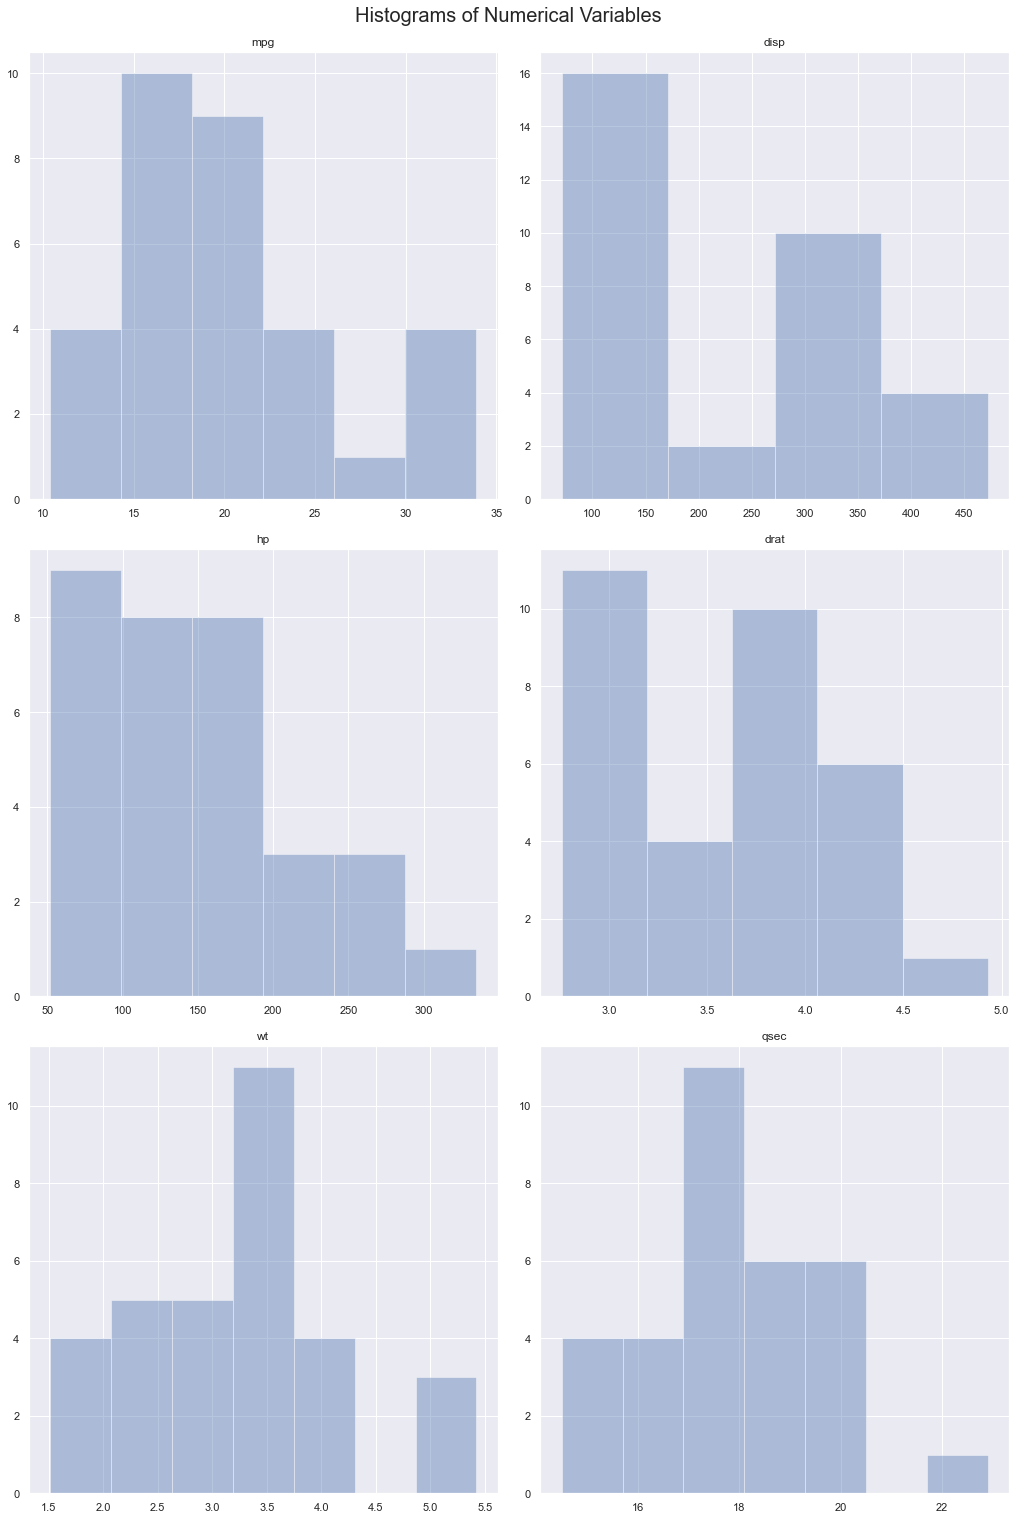

In [18]:
a.histogram()

In [ ]:
a.count_plots()

## Bivariate plots

### Correlation Plots

In [ ]:
a.correlation(target = 'cyl', show_all = True)

### Boxplots

In [ ]:
a.boxplots(target = 'cyl')